# Preambule

In [1]:
library(tidyverse)
library(stringr)
library(caret)
library(dplyr)
library('qs')
library(RRF)
library(ranger)
library(parallel)
library(data.table)
library(ggraph)
library(igraph)
library(inTrees)
library(ggbeeswarm)
library(ggpubr)
library(viridis)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


qs v0.23.4.

RRF 1.9.1

Type rrfNews() to see new features/changes/bug fixes.


Attaching package: ‘RRF’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin



Attaching package: ‘ranger’


The following objec

In [2]:
library(endoR)

Warning message:
“replacing previous import ‘data.table::last’ by ‘dplyr::last’ when loading ‘endoR’”
Warning message:
“replacing previous import ‘data.table::first’ by ‘dplyr::first’ when loading ‘endoR’”
Warning message:
“replacing previous import ‘data.table::between’ by ‘dplyr::between’ when loading ‘endoR’”
Warning message:
“replacing previous import ‘dplyr::union’ by ‘igraph::union’ when loading ‘endoR’”
Warning message:
“replacing previous import ‘dplyr::as_data_frame’ by ‘igraph::as_data_frame’ when loading ‘endoR’”
Warning message:
“replacing previous import ‘dplyr::groups’ by ‘igraph::groups’ when loading ‘endoR’”


In [3]:
library(clustermq)
options(clustermq.scheduler = "sge", clustermq.template = "~/.clustermq.tmpl")

* Option 'clustermq.scheduler' not set, defaulting to ‘SGE’

--- see: https://mschubert.github.io/clustermq/articles/userguide.html#configuration



In [4]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Methanogen_SCFA/Metagenomes_methanogen/envs/r-ml/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] clustermq_0.8.95.1 endoR_0.1.0        viridis_0.5.1      viridisLite_0.3.0 
 [5] ggpubr_0.4.0       ggbeeswarm_0.6.0   inTrees_1.3        igraph_1.2.6      
 [9] ggraph_2.0.4       data.table_1.13.4  ranger_0.12.1      RRF_1.9.1         
[13] qs_0.23.4

# Functions

In [5]:
file.sources <- list.files('../scripts/', pattern = '*.R', full.names=TRUE, ignore.case=TRUE)
for (f in file.sources) {
    source(f)
}
rm('file.sources', 'f')

# Data

## little formatting

In [6]:
meta <- qread('../data/meta_pp.qs') %>% select(-all_of(c('age', 'BMI', 'genderfemale')))
tax <- qread('../data/taxa_nometh.qs') 
pth <- qread('../data/pathways_nometh.qs')
targets <- qread('../data/targets_meth.qs')

In [7]:
pp <- left_join(meta, tax, by = 'Sample') %>% left_join(pth, by = 'Sample') %>% 
            left_join(select(targets, Sample, Mtbc), by = 'Sample') 
target <- as.factor(pp$Mtbc)
pp <- pp %>% select(-Sample, -Mtbc)

In [8]:
dim(pp)

[1] 2203 2315

In [9]:
meta_names <- c(str_subset(colnames(pp), pattern = 'dataset'), 'number_reads')

## get taxa lists for FS

In [10]:
source('../../Common_scripts/get_taxa_lists.R')

In [11]:
tax_names <- qread('../data/taxa_table.qs')
tax_names <- mutate_all(tax_names, endoR::compatibleNames )

In [12]:
tax_names$f <- paste0('f_', tax_names$f)
tax_names$g <- paste0('g_', tax_names$g)
tax_names$s <- paste0('s_', tax_names$s)

In [13]:
families <- lapply(unique(tax_names$f), getFamilies, tax_names = tax_names)
names(families) <- unique(tax_names$f)
genera <- lapply(unique(tax_names$g), getGenera, tax_names = tax_names)
names(genera) <- unique(tax_names$g)
species <- lapply(unique(tax_names$s), getSpecies, tax_names = tax_names)
names(species) <- unique(tax_names$s)

# Fit model

Not the best (#9) but uses way less 
- ntrees = 250
- gamma = 0.4
- k = 0.9
- imbalance strategy = cost-sensitive
- expected kappa on new data = 0.5957346 (best: 0.6004235 +/- 0.02225501)
- expected accuracy on new data = 0.8228788 (best: 0.8246970 +/- 0.0089224)

In [14]:
# mod <- tagRRFRanger_wcase(ix = 1:nrow(pp), data = pp, meta = meta_names, target = target
#                     , families = families,genera = genera, species = species
#                     , num.trees = 250, gamma =0.4, k = 0.9)

In [15]:
# qsave(mod, '../tmp/final_model.qs')

In [16]:
mod <- qread('../tmp/final_model.qs')

In [17]:
X_fs <- select(pp, all_of(unique(mod$confirmed)))

In [18]:
mod %>% summary

          Length Class  Mode     
confirmed 134    -none- character
rf_model   15    ranger list     

In [19]:
mod$rf_model$confusion.matrix

    predicted
true    0    1
   0 1308  202
   1  177  516

# endoR

In [20]:
class_weights <- round(sum(target == '1')/length(target), digits = 2)
class_weights <- c(1-class_weights, class_weights)
class_weights

[1] 0.69 0.31

## Extract and discretize decisions

In [21]:
preclu <- preCluster(model = mod$rf_model, model_type = 'ranger', data = X_fs, target = target
                     , dummy_var = c('dataset_name')
                     , sample_weight = class_weights, classPos = '1'
                     , discretize = TRUE, K = 2, mode = 'model'
                     , times = 100, p = 0.5
                     , in_parallel = TRUE, n_cores = 10
                    )

Extract rules...

Discretise data

Discretise rules



In [27]:
qsave(preclu, '../tmp/Model_preclu_model_disc.qs')

In [21]:
preclu <- qread('../tmp/Model_preclu_model_disc.qs')

## endoR boostrapping

In [22]:
# same function than original + step to save each boostrap (I had issues with the server)
 model2DE_here <- function(i){
    library(data.table)
    res <- model2DE(data = data[partition[[i]], ], target = target[partition[[i]]], 
        exec = exec, classPos = classPos, dummy_var = dummy_var, 
        prune = prune, maxDecay = maxDecay, typeDecay = typeDecay, 
        filter = filter, min_imp = 1, in_parallel = in_parallel, 
        n_cores = n_cores, light = TRUE)
    res <- list(pdecisions = res$n_decisions, rules = res[[length(res) - 
        4]], nodes_agg = res$nodes_agg, edges_agg = res$edges_agg)
    #save the boostrap
    qsave(res, file = paste0(path, 'endoR_b', i, '.qs'))
    return(res)
}

In [23]:
n_cores <- 10
tmpl <- list(conda = "r-ml", cores = n_cores, job_time = '96:00:00', job_mem = '12G')

In [24]:
path <- '/ebio/abt3_projects/temp_data/aruaud/Methano/endoR_B100_new_small/'

In [30]:
endoR_boot <- Q(model2DE_here
  , i = 1:100
  , export=list(data = preclu$data
                , target = target
                , exec = preclu$exec
                , classPos = '1', partition = preclu$partitions
                , prune = TRUE, maxDecay = 0.05, typeDecay = 2 
                , filter = TRUE
                , in_parallel = TRUE, n_cores = n_cores
                , path = path
               )
  , n_jobs= 100
  , pkgs=c('data.table', 'parallel', 'caret', 'stringr', 'scales', 'dplyr', 'inTrees', 'endoR', 'qs')
  , log_worker=FALSE
  , template = tmpl
 )

Warning message in (function (...) :
“Common data is 739.8 Mb. Recommended limit is  (set by clustermq.data.warning option)”
Submitting 100 worker jobs (ID: cmq7708) ...

Running 100 calculations (12 objs/739.8 Mb common; 1 calls/chunk) ...


[--------------------------------------------------]   0% (1/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (2/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (3/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (4/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (5/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (6/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (7/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (8/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (9/100 wrk) eta:  ?s

[------------------------------------

ERROR: Error in private$zmq$poll(sid, timeout): Interrupted system call


## Gather results

In [36]:
#endoR_boot <- list()
#fnames <- tmp <- list.files(path = path, full.names = TRUE)
#for (f in fnames){
#    endoR_boot[[f]] <- qread(file = f)
#}
#names(endoR_boot) <- NULL

In [28]:
qsave(endoR_boot, '../tmp/endoR_boots2.qs')

# Results

In [25]:
endoR_boot <- qread('../tmp/endoR_boots.qs')

## Plot features importance and influence + network

In [26]:
res <- stabilitySelection(rules = endoR_boot, alpha_error = 5, pi_thr = 0.7
                          , aggregate_taxa = FALSE, taxa = tax_names)

287.4008  rules per sub-sample selected. 60 decisions in >= 70 subsets.


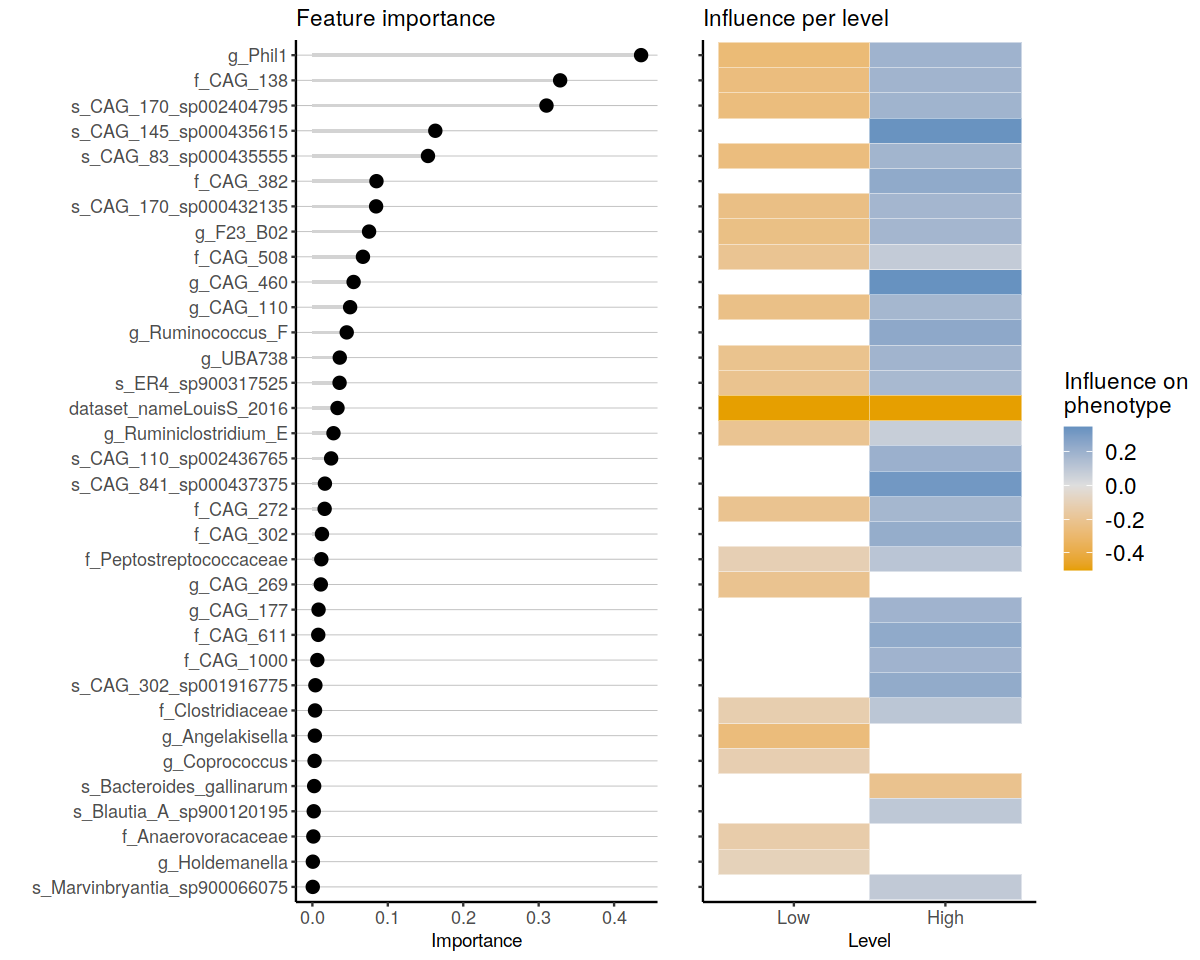

In [27]:
options(repr.plot.width=10, repr.plot.height=8)
plotFeatures(decision_ensemble = res, levels_order = c('Low', 'High'))

In [28]:
tmp <- # we will use the default function + arrange the layout
plotNetwork(decision_ensemble = res#, n_edges = 20
            , colour_edge_low = "#E69F00", colour_node_low = "#E69F00"
            , colour_edge_high = "#0072B2", colour_node_high = "#0072B2"
            , layout = 'fr')+
scale_edge_alpha(range = c(.9,1))+

# layout = just like for ggplot!
theme(legend.text = element_text(size = rel(1))
      , legend.title = element_text(size = rel(1.2), vjust = 0.85)
      , plot.title = element_text(size = rel(1.2), face="plain", vjust = 4.2, hjust = .07)
     )+

# set titles
labs(title = expression("endoR network (B = 100, \u03b1 = 15, "*pi*" = 0.7)")
     , size = 'Importance', edge_width = 'Importance')

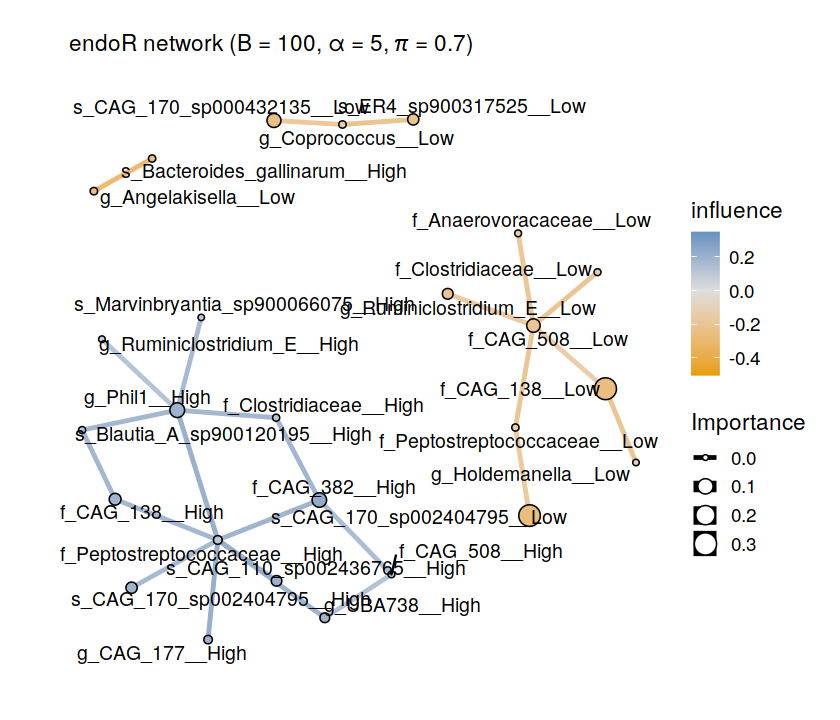

In [32]:
options(repr.plot.width=7, repr.plot.height=6)
# we will use the default function + arrange the layout
plotNetwork(decision_ensemble = res#, n_edges = 20
            , colour_edge_low = "#E69F00", colour_node_low = "#E69F00"
            , colour_edge_high = "#0072B2", colour_node_high = "#0072B2"
            , layout = 'fr')+
scale_edge_alpha(range = c(.9,1))+

# layout = just like for ggplot!
theme(legend.text = element_text(size = rel(1))
      , legend.title = element_text(size = rel(1.2), vjust = 0.85)
      , plot.title = element_text(size = rel(1.2), face="plain", vjust = 4.2, hjust = .07)
     )+

# set titles
labs(title = expression("endoR network (B = 100, \u03b1 = 5, "*pi*" = 0.7)")
     , size = 'Importance', edge_width = 'Importance')

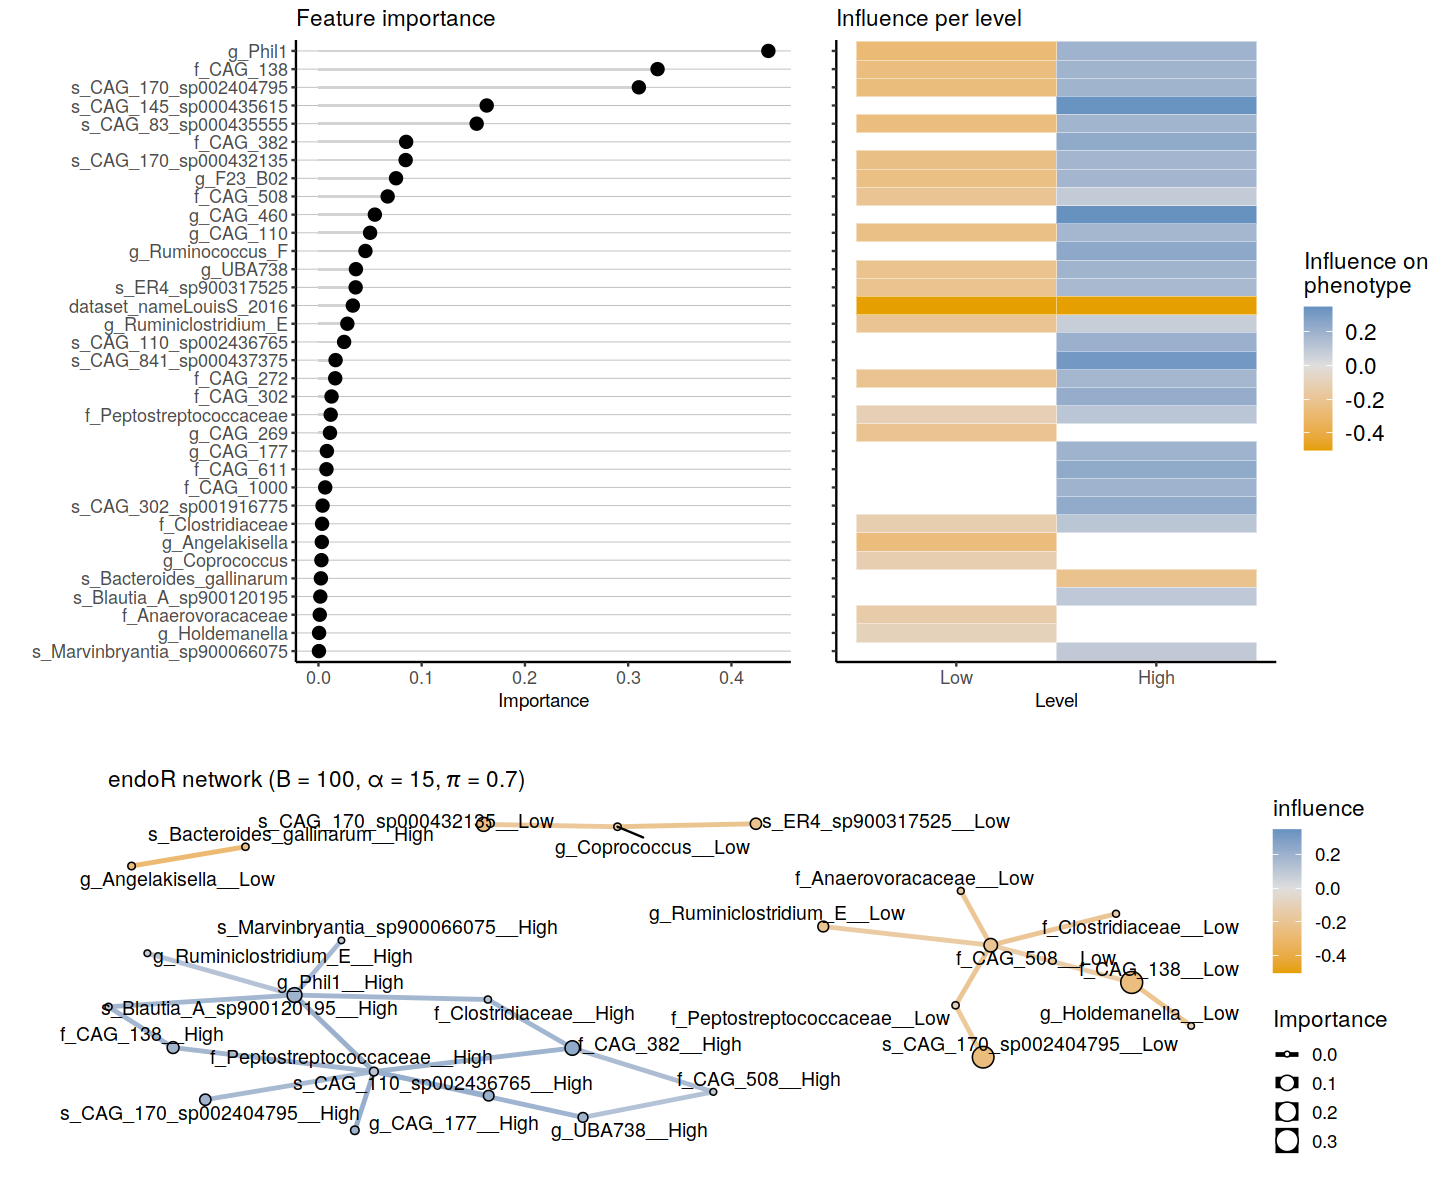

In [33]:
options(repr.plot.width=12, repr.plot.height=10)
suppressWarnings(ggarrange(plotFeatures(decision_ensemble = res, levels_order = c('Low', 'High'))
         , tmp, nrow = 2, ncol = 1, heights = c(0.6, .4)))

# Misc supp plots

## predicted samples vs alpha

In [34]:
check_sampl <- evaluateAlpha(rules = endoR_boot, alphas = c(5, 10, 15, 20, 30), pi_thr = 0.7
                            , data = preclu$data, decision_ensembles = FALSE)

287.4008  rules per sub-sample selected. 60 decisions in >= 70 subsets.
406.4461  rules per sub-sample selected. 75 decisions in >= 70 subsets.
497.7927  rules per sub-sample selected. 84 decisions in >= 70 subsets.
574.8015  rules per sub-sample selected. 95 decisions in >= 70 subsets.
703.9852  rules per sub-sample selected. 106 decisions in >= 70 subsets.


In [35]:
check_sampl 

alpha,n_dec,n_samp
<dbl>,<dbl>,<dbl>
5,60,2203
10,75,2203
15,84,2203
20,95,2203
30,106,2203


In [38]:
al_plot <- ggplot(check_sampl, aes(y = n_samp, x = alpha))+
geom_hline(yintercept = 2203, color = "#00A08A", size = .5)+
geom_vline(xintercept = 5, color = 'darkgrey', linetype = 'longdash')+
geom_line()+
geom_point(aes(size = n_dec))+
theme_classic()+
ylim(c(0, NA))+

scale_size(breaks = c(5, 30, 60, 90))+

labs(x = expression(alpha*' error'), y = '# predicted samples'
     , size = 'Number\ndecisions', title = 'Effect of \u03b1 on the number of predicted samples')+ #expression('Effect of '*alpha*' on the number of predicted samples'))+
theme(axis.title = element_text(size = rel(1.2))
      , axis.text = element_text(size = rel(1))
      , legend.title = element_text(size = rel(1.2))
      , legend.text = element_text(size = rel(1.2))
     )

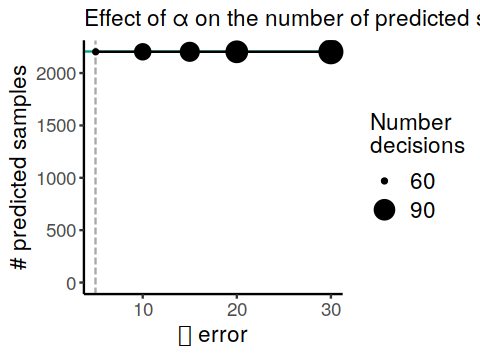

In [39]:
options(repr.plot.width=4, repr.plot.height=3)
al_plot

In [40]:
err_supp <- ggplot(res$rules_summary %>% subset(inN >= 70)
                   , aes(x = support, y = err
                      , shape = as.character(len)
                      , size = imp*n
                      , fill = pred))+
geom_point(alpha = 1, fill = NA)+
geom_point(alpha = .8)+
xlim(c(0, NA))+
theme_classic()+

scale_fill_gradient2(low = "#E69F00", mid = "grey90", high = "#0072B2"
                     , midpoint = .5#, breaks = c(0, .25, .5, .75)
                    )+
scale_shape_manual(values = c(21, 24, 23)
                   , guide = guide_legend(override.aes = list(size = 3)))+
scale_size(breaks = c(0.07, 0.08, 0.09))+

labs(x = 'Support', y = 'Error', shape = '# features'
     , fill = 'Prediction', size = 'Decision\nimportance'
     , title = 'Stable ensemble: \u03b1 = 15')+

theme(axis.title = element_text(size = rel(1.2))
      , axis.text = element_text(size = rel(1))
      , legend.title = element_text(size = rel(1.2))
      , legend.text = element_text(size = rel(1.2))
      , legend.direction = 'vertical', legend.box = "horizontal"
     )

In [41]:
p_stable <- ggarrange(al_plot, err_supp, ncol = 2, widths = c(.4, .6), labels = c('A', 'B'))

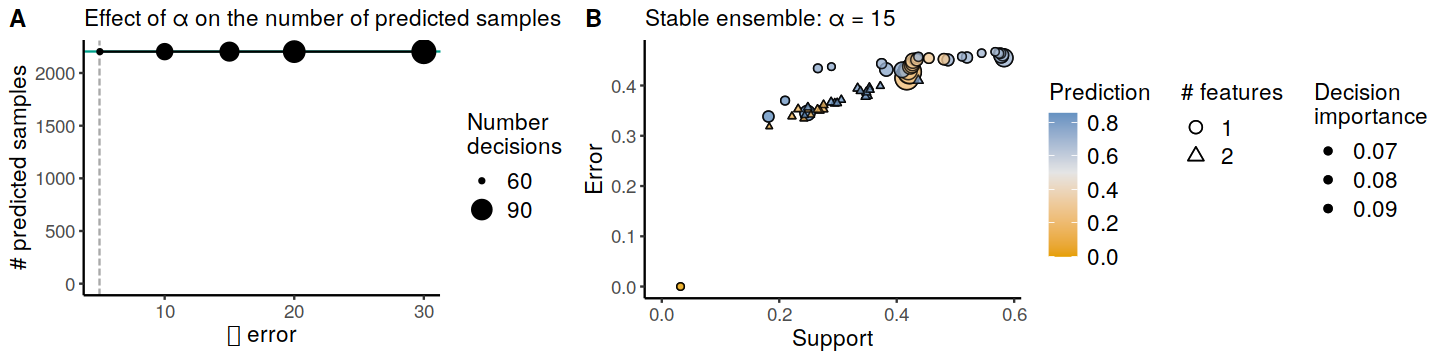

In [42]:
options(repr.plot.width=12, repr.plot.height=3)
p_stable

In [68]:
res$rules_summary %>% subset(inN >= 70) %>% sapply(mean) %>% sapply(round, digits = 2)
res$rules_summary %>% subset(inN >= 70) %>% sapply(sd)%>% sapply(round, digits = 2)

Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”


condition       inN       len   support       err      pred       imp    imp_sd 
       NA     89.30      1.42      0.37      0.40      0.54      0.06      0.01 
        n      n_sd 
     9.17      3.22

Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“NAs introduced by coercion”


condition       inN       len   support       err      pred       imp    imp_sd 
       NA      9.97      0.50      0.12      0.07      0.28      0.02      0.00 
        n      n_sd 
    13.68      3.85

## gini vs endoR

In [43]:
fs <- mod$confirmed[-c(1:length(meta_names))]
length(fs)
#fs

[1] 107

In [44]:
gini <- data.frame(Feature = names(mod$rf_model$variable.importance) 
                   , Gini = mod$rf_model$variable.importance) %>% 
            arrange(-Gini)

In [45]:
agg_imp <- copy(res$nodes)
agg_imp$Feature <- str_replace(agg_imp$var, pattern = '\\_{2}.*', replacement = '')
agg_imp <- group_by(agg_imp, Feature) %>% summarise(importance = sum(importance)) %>% arrange(-importance)

`summarise()` ungrouping output (override with `.groups` argument)



In [46]:
gini <- gini %>% left_join(agg_imp, by = 'Feature')
gini$importance[is.na(gini$importance)] <- 0

In [47]:
gini$shape <- ifelse(gini$importance > 0, TRUE, FALSE)

In [48]:
# add color per taxa 
christen <- tax_names %>% subset(o == 'Christensenellales', select= c(f, g,s)) %>% unlist %>% unique
oscillo <- tax_names %>% subset(o == 'Oscillospirales', select= c(f, g,s)) %>% unlist %>% unique
tanb <- tax_names %>% subset(o == 'TANB77', select= c(f, g,s)) %>% unlist %>% unique

In [49]:
gini$colo <- 'grey'
gini$colo[gini$Feature %in% christen] <- '#cb3b7e'
gini$colo[gini$Feature %in% oscillo] <- '#7262e8'
gini$colo[gini$Feature %in% tanb] <- '#2fa560'

In [59]:
gini_imp <- ggplot(gini, aes(x = log10(importance), y = Gini, shape = shape, fill = colo))+

geom_point(alpha = .7, size = 4)+
theme_classic()+

labs(x = 'endoR importance (log10)', y = 'Gini importance'
     , fill = 'Taxonomic groups', shape = 'in decisions'
     , title = 'Stable ensemble: \u03b1 = 5')+

scale_shape_manual(values = c(21,24))+

scale_fill_manual(values = unique(gini$colo)
                   , breaks = unique(gini$colo)
                   , labels = c('Christensenellales', 'Oscillospirales', 'TANB77', 'Other')) +

guides(fill = guide_legend(override.aes = list(shape = 22, alpha = 1, size = 5)))+


theme(axis.title = element_text(size = rel(1.2))
      , axis.text = element_text(size = rel(1))
      , legend.title = element_text(size = rel(1.2))
      , legend.text = element_text(size = rel(1.2))
     )

In [51]:
gini$Feature <- factor(gini$Feature, levels = gini$Feature[order(gini$Gini)])

gini_topfeat <- ggplot(gini %>% top_n(n = 10, Gini), aes(x = Feature, y = Gini)) + 
geom_col(fill = "lightgray", width = 0.1) + 
geom_point(size = 3, aes(fill = colo, shape = shape)) + 
scale_shape_manual(values = c(21,24))+

scale_fill_manual(values = unique(gini$colo)
                   , breaks = unique(gini$colo)
                   , labels = c('Christensenellales', 'Oscillospirales', 'TANB77', 'Other')) +

guides(fill = guide_legend(override.aes = list(shape = 22, alpha = 1, size = 5)))+
coord_flip()+
theme_classic() + 
theme(axis.text.y = element_text(size = rel(1.2))
      , axis.title.x = element_text(size = rel(1.2), hjust = .5)
      , legend.text = element_text(size = rel(1.2))
      , legend.title = element_text(size = rel(1.2))
      , plot.title = element_text(size = rel(1.2), hjust = 1)
      ) + 
labs(x = "", y = 'Gini importance', title = 'Gini importance: top 10 features'
    , fill = 'Taxonomic groups', shape = 'In stable decision\nensemble')

In [52]:
gini$Feature <- factor(gini$Feature, levels = gini$Feature[order(-gini$Gini)])

gini_allfeat <- ggplot(gini, aes(x = Feature, y = Gini)) + 
geom_col(fill = "lightgray", width = 0.1) + 
geom_vline(xintercept = 10.5, color = "#00A08A", size = .5, linetype = 'dashed')+
geom_point(size = 2, aes(fill = colo, shape = shape)) + 
scale_shape_manual(values = c(21,24))+

scale_fill_manual(values = unique(gini$colo)
                   , breaks = unique(gini$colo)
                   , labels = c('Christensenellales', 'Oscillospirales', 'TANB77', 'Other')) +

theme_classic() + 
theme(axis.text.y = element_text(size = rel(1.2)), legend.position = 'none'
      , axis.text.x = element_blank()
      , axis.title.y = element_text(size = rel(1.2))
      , legend.text = element_text(size = rel(1.2))
      , plot.title = element_text(size = rel(1.2))
      ) + 
labs(x = "", y = '\nGini importance', title = 'Gini importance: all selected features')+
annotate(geom = 'text', x = 15, y = 40, label = 'bold("Top 10")', color = "#00A08A", size = 5, parse = TRUE)

## 10 CV versus Gini and endoR

In [53]:
fs <- readRDS(file = '../tmp/FS_10cv.RDS')

In [54]:
fs <- gini %>%  left_join(fs, by = 'Feature')

In [55]:
fs$n[is.na(fs$n)] <- 0

In [56]:
fs_gini <- ggplot(fs, aes(x = n, y = Gini, shape = shape, fill = colo)) + 
geom_point(alpha = .7, size = 4)+
theme_classic()+

labs(x = '# times selected during CV', y = 'Gini importance'
     , fill = 'Taxonomic groups', shape = 'in decisions'
     , title = 'CV versus final model')+

scale_shape_manual(values = c(21,24))+

scale_fill_manual(values = unique(fs$colo)
                   , breaks = unique(fs$colo)
                   , labels = c('Christensenellales', 'Oscillospirales', 'TANB77', 'Other')) +

guides(fill = guide_legend(override.aes = list(shape = 22, alpha = 1, size = 5)))+


theme(axis.title = element_text(size = rel(1.2))
      , axis.text = element_text(size = rel(1))
      , legend.title = element_text(size = rel(1.2))
      , legend.text = element_text(size = rel(1.2))
     )

In [60]:
gini_plot_r1 <- ggarrange(gini_topfeat, fs_gini, gini_imp, labels = c('A', 'B', 'C'), legend = 'right'
                          ,hjust = c(-0.5, -0.5, -1.75), common.legend = TRUE, ncol = 3
                         , widths = c(1, 0.8, 0.8))

gini_plot <- ggarrange(gini_plot_r1, gini_allfeat, labels = c(NA, 'D'), ncol = 1, nrow = 2)

Warning message:
“Removed 1 rows containing missing values (geom_text).”


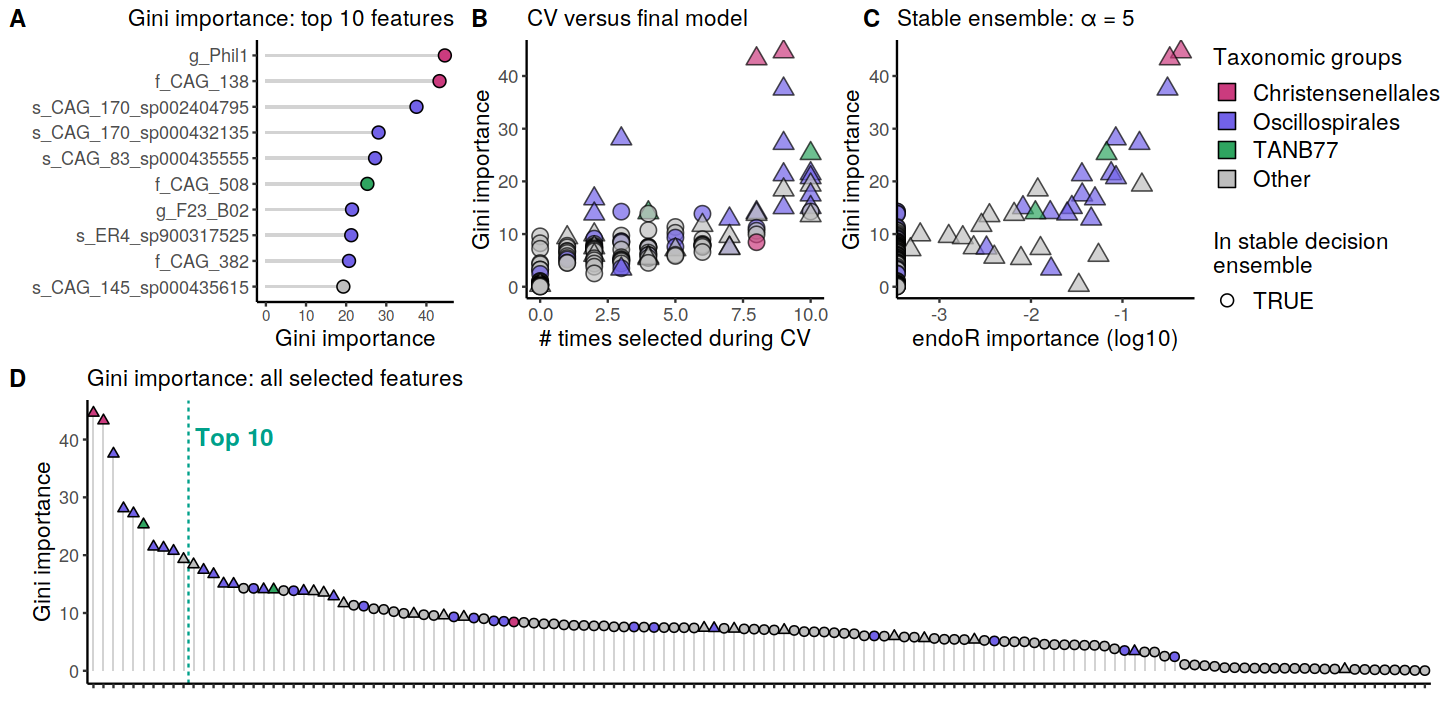

In [61]:
options(repr.plot.width=12, repr.plot.height=6)

gini_plot

## save importances for GSEA

In [62]:
gini %>% head(3)

,Feature,Gini,importance,shape,colo
,<fct>,<dbl>,<dbl>,<lgl>,<chr>
1,g_Phil1,44.60070,0.4358004,TRUE,#cb3b7e
2,f_CAG_138,43.27363,0.3284668,TRUE,#cb3b7e
3,s_CAG_170_sp002404795,37.53236,0.3103565,TRUE,#7262e8


In [63]:
qsave(gini %>% select(Feature, Gini, importance), '../tmp/Variable_importance.qs')

In [ ]:
res$rules_summary %>% subset(inN >= 70) %>% presentRules(colN = colnames(preclu$data)) %>% arrange(-imp)